# Naive Bayes decoder for position decoding based on DLC tracking

Here we will use scikit-learn Naive Bayes decoder in order to decode animals positions from calcium neural traces using as labels DLC tracking information.


In [1]:
#import useful libraries
import os
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
import pickle
import configuration
import general_statistics as stats
import figures as figs
import matplotlib.cm as cm
from matplotlib import colors
from scipy import signal
from scipy import stats as sstats
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import scipy
cmap = cm.jet
import math

In [207]:
# define mouse information, and preprocessin versions from analysis.
# load data for all sessions in this mouse and compute mean activity for each neuron.

mouse = 32365        ### mouse number id
decoding_v = 1            ## decoding version, normaly equal to one
motion_correction_v = 20  ### 100 means everything was aligned, 200 means it was also equalized, 20 is for day wise
alignment_v = 3           ## alignment version, version 3 is for day wise
equalization_v = 0        ## equalization version
source_extraction_v = 1   ## source extraction version
component_evaluation_v = 1 ## component evaluation version

# here we will do analysis with no registration
# registration_v = 2        ## registration version
sf = 10                   ## sampling frequency of the original signal 
re_sf= 1                 ## value of resampling
session_now = 2
BINS = 70
period = int(1 * sf / re_sf)
period_resting = period *10
fixed = 'None'
## define task for plotting. This will cahnge for other mice!!!!

if mouse == 56165 or mouse == 32364:
    if mouse == 56165:
        sessions = [1,2,4]       ## sessions for this particular mouse
    if mouse == 32364:
        sessions = [1,2]
    if session_now == 1:
        task = 'OVERLAPPING'
        colapse_behaviour = 1
        labels =['Unlabel','Rest1', 'Navigation', 'Obj1' , 'Obj2', 'Run1', 'Run2']
        colornames=['k',"r","deepskyblue","g","blue","g","blue"]
        if mouse == 32364:
            fixed = 'LR'
            object_fixed = 4
            colapse_behaviour = 1
            labels =['Unlabel','Rest1', 'Navigation', 'Overlap_object' , 'Moving_object','RunOO' , 'RunMO' ]
            colornames=['k',"r","deepskyblue","g","blue","g","blue"]   
        if mouse == 56165:
            fixed = 'UR'
            object_fixed = 5
            colapse_behaviour = 1
            labels =['Unlabel','Rest1', 'Navigation', 'Overlap_object' , 'Moving_object','RunOO' , 'RunMO' ]
            colornames=['k',"r","deepskyblue","g","blue","g","blue"]   

    else:
        if session_now == 2:
            task = 'STABLE'
            colapse_behaviour = 2
            labels =['Unlabel','Rest1', 'Navigation', 'Obj1' , 'Obj2', 'Run1', 'Run2']
            colornames=['k',"r","deepskyblue","g","blue","g","blue"]
        else:
            task = 'RANDOM'
            colapse_behaviour = 0
            labels =['Unlabel','Rest1', 'Navigation', 'Obj1' , 'Obj2', 'Run1', 'Run2']
            colornames=['k',"r","deepskyblue","g","blue","g","blue"]
            
if mouse == 32365:
    sessions = [2,3] ## sessions for this particular mouse
    if session_now == 2:
        task = 'RANDOM'
        colapse_behaviour = 0
        labels =['Unlabel','Rest1', 'Navigation', 'Obj1' , 'Obj2', 'Run1', 'Run2']
        colornames=['k',"r","deepskyblue","g","blue","g","blue"]
    else:
        if session_now == 3:
            task = 'OVERLAPPING'
            fixed = 'LR'
            object_fixed = 4
            colapse_behaviour = 1
            labels =['Unlabel','Rest1', 'Navigation', 'Overlap_object' , 'Moving_object','RunOO' , 'RunMO' ]
            colornames=['k',"r","deepskyblue","g","blue","g","blue"]           
            
if mouse == 56166:
    sessions = [1,2] ## sessions for this particular mouse
    if session_now == 1:
        task = 'RANDOM'
        colapse_behaviour = 0
        labels =['Unlabel','Rest1', 'Navigation', 'Obj1' , 'Obj2', 'Run1', 'Run2']
        colornames=['k',"r","deepskyblue","g","blue","g","blue"]

    else:
        if session_now == 2:
            task = 'OVERLAPPING'
            fixed = 'UR'
            object_fixed = 5
            colapse_behaviour = 1
            labels =['Unlabel','Rest1', 'Navigation', 'Overlap_object' , 'Moving_object','RunOO' , 'RunMO' ]
            colornames=['k',"r","deepskyblue","g","blue","g","blue"]
            
if mouse == 32366:
    sessions = [2,3] ## sessions for this particular mouse
    if session_now == 3:
        task = 'RANDOM'
        colapse_behaviour = 0
        labels =['Unlabel','Rest1', 'Navigation', 'Obj1' , 'Obj2', 'Run1', 'Run2']
        colornames=['k',"r","deepskyblue","g","blue","g","blue"]
            
if mouse == 32363:
    sessions = [1,2] ## sessions for this particular mouse
    if session_now == 1:
        task = 'RANDOM'
        colapse_behaviour = 0
        labels =['Unlabel','Rest1', 'Navigation', 'Obj1' , 'Obj2', 'Run1', 'Run2']
        colornames=['k',"r","deepskyblue","g","blue","g","blue"]
    else:
        if session_now == 2:
            task = 'OVERLAPPING'
            fixed = 'UL'
            object_fixed = 6
            colapse_behaviour = 1
            labels =['Unlabel','Rest1', 'Navigation', 'Overlap_object' , 'Moving_object','RunOO' , 'RunMO' ]
            colornames=['k',"r","deepskyblue","g","blue","g","blue"]

In [208]:
file_directory = os.environ['PROJECT_DIR'] + 'neural_analysis/data/calcium_activity_day_wise/'
timeline_file_dir = os.environ['PROJECT_DIR'] + 'neural_analysis/data/timeline/'
behaviour_dir = os.environ['PROJECT_DIR'] + 'calcium_imaging_behaviour/data/ethogram/' + f'{mouse}' + '/session_' + f'{session_now}' + '/'
tracking_dir = os.environ['PROJECT_DIR'] + 'calcium_imaging_behaviour/data/center_of_mass/' + f'{mouse}' + '/session_' + f'{session_now}' + '/'
objects_dir= os.environ['PROJECT_DIR'] + 'calcium_imaging_behaviour/data/object_positions/'
figure_path = os.environ['PROJECT_DIR'] +'neural_analysis/figures/'

In [209]:
# define all relevant files names and load them into a list
session = session_now

activity_list = []
timeline_list = []
behaviour_list = []
tracking_list = []
total_time = 0
day = 0
for trial in [1,6,11,16]:
    
    beh_file_name_1 = 'mouse_' + f'{mouse}' + '_session_' + f'{session}' + '_day_' + f'{day+1}' + '_likelihood_0.75_ethogram.npy'
    ## LOAD BEHAVIOUR
    behaviour = np.load(behaviour_dir + beh_file_name_1)
    reshape_behaviour = np.reshape(behaviour[:int(int(behaviour.shape[0]/re_sf)*re_sf)],(int(behaviour.shape[0]/re_sf),re_sf))
    resample_beh1 = np.reshape(scipy.stats.mode(reshape_behaviour,axis=1)[0],reshape_behaviour.shape[0])
    
    ## LOAD TRACKING
    tracking_file_name_1 = 'mouse_' + f'{mouse}' + '_session_' + f'{session}' + '_day_' + f'{day+1}' + '_likelihood_0.75.npy'
    position = np.load(tracking_dir + tracking_file_name_1)
    resample_position, resample_position_stc = stats.resample_matrix(neural_activity=position.T,
                                                                                        re_sf=re_sf)
    ## LOAD TIMELINE
    time_file_session_1 =  'mouse_'+ f'{mouse}'+'_session_'+ f'{session}' +'_trial_'+ f'{trial}'+'_v1.3.1.0_10.pkl'

    timeline_file= open(timeline_file_dir + time_file_session_1,'rb')
    timeline_info = pickle.load(timeline_file)
    timeline_1 = np.zeros(len(timeline_info) + 1)
    for i in range(len(timeline_info)):
        timeline_1[i] = timeline_info[i][1]
    timeline_1[len(timeline_info)] = behaviour.shape[0]
    timeline = timeline_1/re_sf
    time_lenght = 10
    resample_timeline = timeline_1/re_sf
    timeline_list.append(resample_timeline)
    
    behaviour_list.append(resample_beh1)
    tracking_list.append(resample_position)
    total_time = total_time + behaviour.shape[0]
    
    
    file_name_session_1 = 'mouse_' + f'{mouse}' + '_session_' + f'{session}' + '_trial_'+ f'{trial}'+'_v' + f'{decoding_v}' + '.4.' + f'{motion_correction_v}' + \
                          '.' + f'{alignment_v}' + '.' + f'{equalization_v}' + '.' + f'{source_extraction_v}' + '.' + \
                          f'{component_evaluation_v}' +  '.0.npy'

    ##load activity and timeline
    activity = np.load(file_directory + file_name_session_1)
    neural_activity1 = activity[1:,:]
    ## z-score neural activity
    neural_activity = neural_activity1
    ##downsample neural activity
    resample_neural_activity_mean, resample_neural_activity_std = stats.resample_matrix(neural_activity=neural_activity,
                                                                                        re_sf=re_sf)
    
    activity_list.append(resample_neural_activity_mean)
    
    day = day + 1

In [210]:
from scipy.ndimage import gaussian_filter

def occupancy_map(tracking = None, binnumber = BINS):
    xpos = [int(tracking[0,i]) for i in range(tracking.shape[1])]
    ypos = [int(tracking[1,i]) for i in range(tracking.shape[1])]
    occupancy = np.zeros((binnumber,binnumber))
    
    xdenom = int(np.max(xpos)/binnumber+1)
    ydenom = int(np.max(ypos)/binnumber+1)
    data_points = 0
    for x,y in zip(xpos,ypos):
        if x>0 and y>0:
            x1 = int(x/xdenom)
            y1 = int(y/ydenom)
            occupancy [x1,y1]= occupancy[x1,y1] + 1
            data_points+=1
    occupancy = occupancy/data_points
    return occupancy

def binned_tracking(tracking = None, binnumber = 70):
    
    xpos = [int(tracking[0,i]) for i in range(tracking.shape[1])]
    ypos = [int(tracking[1,i]) for i in range(tracking.shape[1])]
    
    
    xdenom = int(np.max(xpos)/binnumber+1)
    ydenom = int(np.max(ypos)/binnumber+1)
    
    xnew = [int(xpos[i]/xdenom) for i in range(tracking.shape[1])]
    ynew = [int(ypos[i]/xdenom) for i in range(tracking.shape[1])]
    
    return xnew,ynew

def neuron_activity_map(activity= None,tracking = None,binnumber = 70, neurinID = 0):
    
    xpos = [int(tracking[0,i]) for i in range(tracking.shape[1])]
    ypos = [int(tracking[1,i]) for i in range(tracking.shape[1])]
    act_map = np.zeros((binnumber,binnumber))
    xdenom = int(np.max(xpos)/binnumber+1)
    ydenom = int(np.max(ypos)/binnumber+1)
    counter = 0
    for x,y in zip(xpos,ypos):
        if x>0 and y>0:
            x1 = int(x/xdenom)
            y1 = int(y/ydenom)
            act_map[x1,y1]+=np.mean(activity[neuronID,counter])
            counter+=1
        
    act_map = act_map/counter
    return act_map

def mean_activity_map(activity= None,tracking = None,binnumber = BINS):
    
    xpos = [int(tracking[0,i]) for i in range(tracking.shape[1])]
    ypos = [int(tracking[1,i]) for i in range(tracking.shape[1])]
    act_map = np.zeros((binnumber,binnumber))
    xdenom = int(np.max(xpos)/binnumber+1)
    ydenom = int(np.max(ypos)/binnumber+1)
    counter = 0
    for x,y in zip(xpos,ypos):
        if x>0 and y>0:
            x1 = int(x/xdenom)
            y1 = int(y/ydenom)
            act_map[x1,y1]+=np.mean(activity[:,counter])
            counter+=1
        
    act_map = act_map/counter
    return act_map

def speed_selection(tracking = None, speed_limit = 3):
    
    x = tracking[0,:]
    y = tracking[1,:]
    vx = np.diff(x)
    vy = np.diff(y)
    speed = np.sqrt(vx*vx+vy*vy)
    index = np.where(speed > speed_limit)[0]
    
    return index

def poisson_pdf(n,l):
    return pow(l,n)*exp(-l)/math.factorial(n)

## Maps characterization

/home/melisa/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide


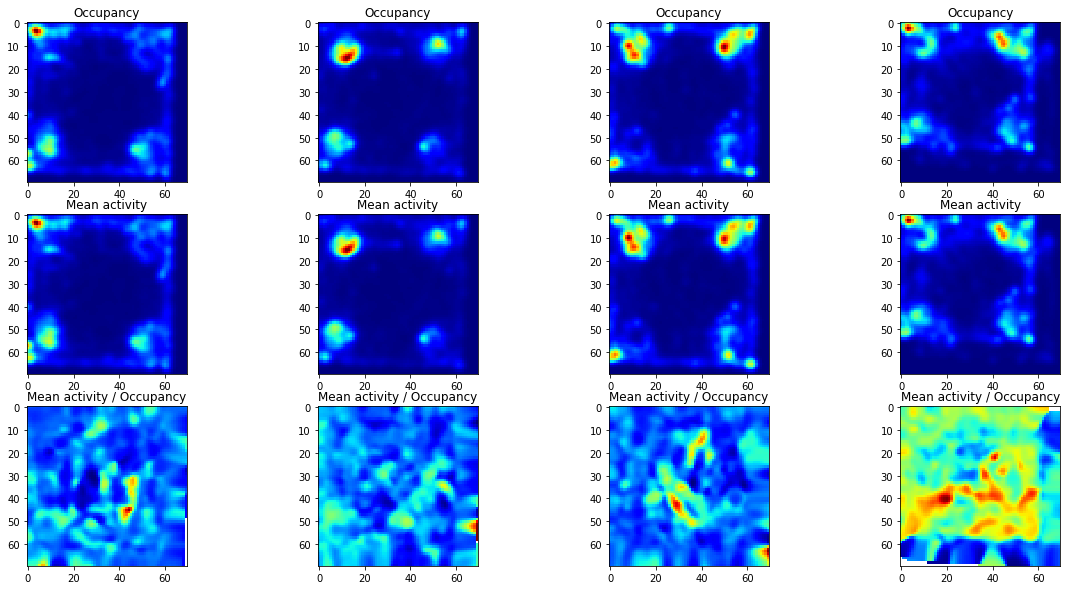

In [211]:
from scipy.ndimage import gaussian_filter
sigma = 1.5

figure = plt.figure(figsize=(20, 10))
gs = figure.add_gridspec(3, 4)

for day in range(4):
    
    occupancy = occupancy_map(tracking_list[day],binnumber = BINS)
    activity_map_variable = mean_activity_map(activity_list[day],tracking_list[day], binnumber = BINS)

    occupancy = gaussian_filter(occupancy, sigma)
    activity_map_variable = gaussian_filter(activity_map_variable, sigma)
    
    axes0 = figure.add_subplot(gs[0,day])
    axes1 = figure.add_subplot(gs[1, day])
    axes2 = figure.add_subplot(gs[2, day])

    axes0.imshow(occupancy, cmap = 'jet')
    axes0.set_title('Occupancy')
    axes1.imshow(activity_map_variable, cmap='jet')
    axes1.set_title('Mean activity')
    axes2.imshow(activity_map_variable/occupancy, cmap = 'jet')
    axes2.set_title('Mean activity / Occupancy')

## NaiveBayes from SKlearn

(10197, 285)


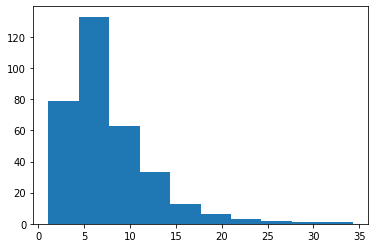

In [212]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB

day = 0
FR_limit = 12

index = speed_selection(tracking_list[day], speed_limit = 3)
tracking = tracking_list[day][:,index]
ypre = np.array(binned_tracking(tracking = tracking, binnumber = BINS )).T
binsx = ypre[np.where(np.logical_and(ypre[:,0]>0,ypre[:,1]>0))[0],0]
binsy = ypre[np.where(np.logical_and(ypre[:,0]>0,ypre[:,1]>0))[0],1]

Xpre = activity_list[day].T
Xpre = Xpre[np.where(np.logical_and(ypre[:,0]>0,ypre[:,1]>0))[0],:]
firing_rate = np.mean(Xpre,axis = 0)*10
selected_cells = np.where(firing_rate < FR_limit)[0]
X = Xpre[:,selected_cells]
#X = X.astype(int)

y = [binsx[i]*BINS + binsy[i] for i in range(len(binsx))]

plt.hist(firing_rate)
print(X.shape)

#### Naive Bayes with Gaussian model

In [213]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)
gnb = GaussianNB()
y_pred = gnb.fit(X_train, y_train).predict(X_test)

In [214]:
print("Number of mislabeled points out of a total %d points : %d" % (X_test.shape[0], (y_test != y_pred).sum()))

Number of mislabeled points out of a total 1020 points : 914


In [215]:
y_train_x = [int(y_train[i]/BINS) for i in range(len(y_train))]
y_train_y = [y_train[i]%BINS for i in range(len(y_train))]

y_test_x = [int(y_test[i]/BINS) for i in range(len(y_test))]
y_test_y = [y_test[i]%BINS for i in range(len(y_test))]

occupancy_train = occupancy_map(np.array([y_train_x,y_train_y]),binnumber = BINS)
occupancy_train = gaussian_filter(occupancy_train, sigma)

occupancy_test = occupancy_map(np.array([y_test_x,y_test_y]),binnumber = BINS)
occupancy_test = gaussian_filter(occupancy_test, sigma)

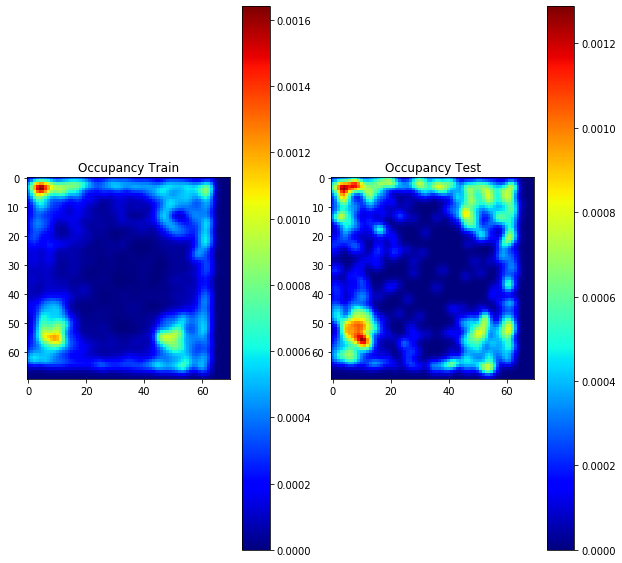

In [216]:
figure = plt.figure(figsize=(10, 10))
gs = figure.add_gridspec(1, 2)
axes0 = figure.add_subplot(gs[0,0])
axes1 = figure.add_subplot(gs[0,1])

pos0 = axes0.imshow(occupancy_train, cmap = 'jet')
axes0.set_title('Occupancy Train')
figure.colorbar(pos0, ax=axes0)
pos1 = axes1.imshow(occupancy_test, cmap = 'jet')
axes1.set_title('Occupancy Test')
figure.colorbar(pos1, ax=axes1)


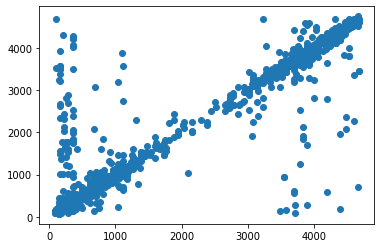

In [217]:
plt.scatter(y_pred,y_test)

In [218]:
y_pred_x = [int(y_pred[i]/BINS) for i in range(len(y_pred))]
y_pred_y = [y_pred[i]%BINS for i in range(len(y_pred))]

y_test_x = [int(y_test[i]/BINS) for i in range(len(y_test))]
y_test_y = [y_test[i]%BINS for i in range(len(y_test))]

x_dist = np.array([ y_pred_x[i] - y_test_x[i] for i in range(len(y_pred_x))])
y_dist = np.array([ y_pred_y[i] - y_test_y[i] for i in range(len(y_pred_x))])
     
distance = np.sqrt((x_dist)*(x_dist)+(y_dist)*(y_dist))
print('MeanError: ' + str(np.mean(distance)) + ' Std: ' + str(np.std(distance)))
print('MeanErrorProp: ' + str(np.mean(distance)/BINS) + ' PRopStd: ' + str(np.std(distance)/BINS))

MeanError: 6.911690112886716 Std: 13.322695900527558
MeanErrorProp: 0.09873843018409595 PRopStd: 0.19032422715039368


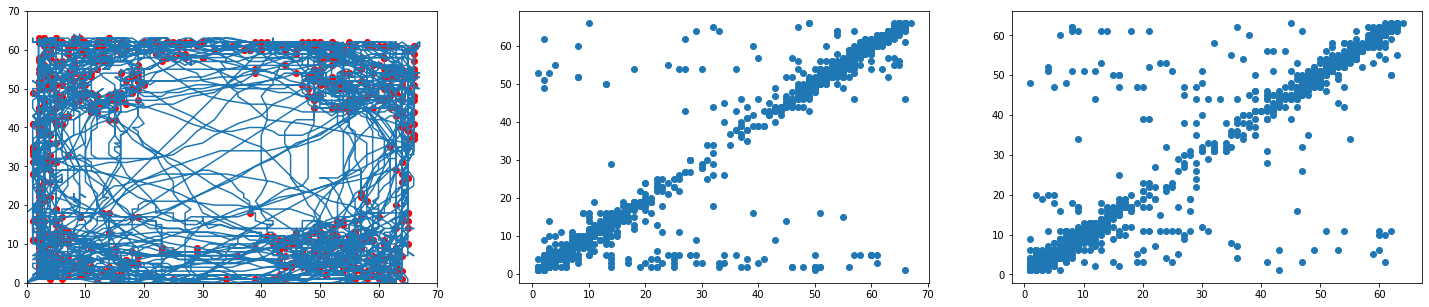

In [219]:
figure , axes = plt.subplots(1,3)
axes[0].plot(ypre[:,0],ypre[:,1])
axes[0].scatter(y_pred_x,y_pred_y,color = 'r')
axes[0].set_xlim([0,BINS])
axes[0].set_ylim([0,BINS])

axes[1].scatter(y_test_x,y_pred_x)

axes[2].scatter(y_test_y,y_pred_y)
figure.set_size_inches(25,5)


In [220]:
from sklearn.metrics import confusion_matrix
confx = confusion_matrix(y_test_x,y_pred_x)
confy = confusion_matrix(y_test_y,y_pred_y)

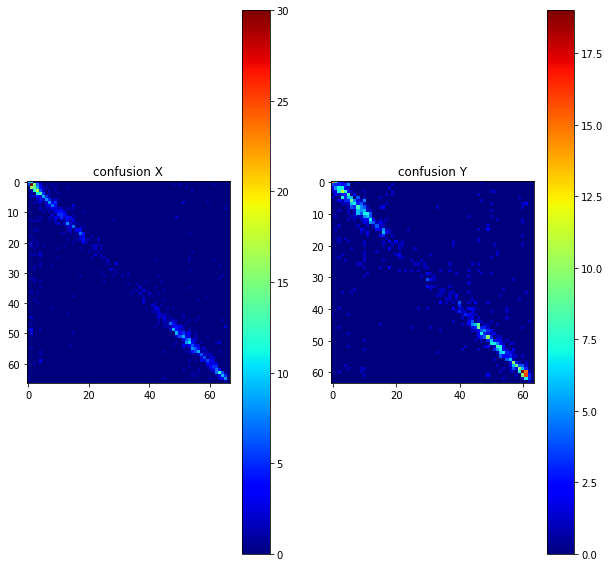

In [221]:
figure = plt.figure(figsize=(10, 10))
gs = figure.add_gridspec(1, 2)
axes0 = figure.add_subplot(gs[0,0])
axes1 = figure.add_subplot(gs[0,1])

pos0 = axes0.imshow(confx, cmap = 'jet')
axes0.set_title('confusion X')
figure.colorbar(pos0, ax=axes0)
pos1 = axes1.imshow(confy, cmap = 'jet')
axes1.set_title('confusion Y')
figure.colorbar(pos1, ax=axes1)

## Poisson Naive Bayes

In [222]:
### TO BE CONSTRUCTED

## Gaussian Naive Bayes for trial to trial decoding

In [223]:
activity_list[day].shape

(334, 31774)

In [224]:
day = 0
FR_limit = 10

X = []
y = []
X_shuffle = []
ypre_list = []
for day in range(4):
    for trial in range(5):
        time0 = int(timeline_list[day][trial*2])
        time1 = int(timeline_list[day][trial*2+1])

        tracking_trial = tracking_list[day][:,time0:time1]
        index = speed_selection(tracking_trial, speed_limit = 3)

        tracking = tracking_trial[:,index]
        ypre = np.array(binned_tracking(tracking = tracking, binnumber = BINS )).T
        ypre_list.append(ypre)
        binsx = ypre[np.where(np.logical_and(ypre[:,0]>0,ypre[:,1]>0))[0],0]
        binsy = ypre[np.where(np.logical_and(ypre[:,0]>0,ypre[:,1]>0))[0],1]

        Xpre = activity_list[day][:,time0:time1].T
        Xpre = Xpre[np.where(np.logical_and(ypre[:,0]>0,ypre[:,1]>0))[0],:]
        firing_rate = np.mean(Xpre,axis = 0)*10
        selected_cells = np.where(firing_rate < FR_limit)[0]
        X_decode = Xpre[:,selected_cells]
        X.append(X_decode.copy())
        np.random.shuffle(X_decode)
        X_shuffle.append(X_decode)
        y.append([binsx[i]*BINS + binsy[i] for i in range(len(binsx))])

In [225]:
print(type(X_shuffle[0]))
y_test_list = []
y_pred_list = []
y_pred_list_shuffle = []
y_test_list_shuffle = []

for trial in range(5*4): 
    X_train, X_test, y_train, y_test = train_test_split(X[trial], y[trial], test_size=0.1, random_state=0)
    X_train_shuffle , X_test_shuffle , y_train_shuffle, y_test_shuffle = train_test_split(X_shuffle[trial], y[trial], test_size=0.1, random_state=0)
    gnb = GaussianNB()
    y_pred = gnb.fit(X_train, y_train).predict(X_test)
    y_test_list.append(y_test)
    y_pred_list.append(y_pred)
    
    y_pred_shuffle = gnb.fit(X_train_shuffle, y_train_shuffle).predict(X_test_shuffle)
    y_test_list_shuffle.append(y_test_shuffle)
    y_pred_list_shuffle.append(y_pred_shuffle)
    print("Number of mislabeled points out of a total %d points : %d" % (X_test.shape[0], (y_test != y_pred).sum()))

<class 'numpy.ndarray'>
Number of mislabeled points out of a total 222 points : 194
Number of mislabeled points out of a total 212 points : 194
Number of mislabeled points out of a total 201 points : 184
Number of mislabeled points out of a total 195 points : 169
Number of mislabeled points out of a total 186 points : 167
Number of mislabeled points out of a total 194 points : 177
Number of mislabeled points out of a total 141 points : 113
Number of mislabeled points out of a total 233 points : 216
Number of mislabeled points out of a total 193 points : 177
Number of mislabeled points out of a total 139 points : 119
Number of mislabeled points out of a total 205 points : 182
Number of mislabeled points out of a total 183 points : 158
Number of mislabeled points out of a total 161 points : 139
Number of mislabeled points out of a total 112 points : 88
Number of mislabeled points out of a total 144 points : 134
Number of mislabeled points out of a total 184 points : 157
Number of mislabe

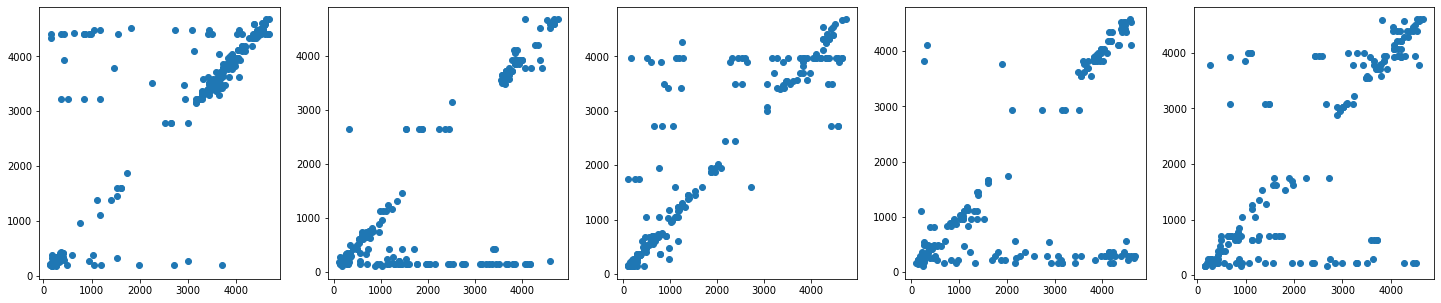

In [226]:
figure, axes = plt.subplots(1,5)
for trial in range(5):
    axes[trial].scatter(y_test_list[trial],y_pred_list[trial])
figure.set_size_inches(25,5)

MeanError: 10.573481655541764 Std: 17.518038299424454
MeanErrorProp: 0.1510497379363109 PRopStd: 0.2502576899917779
MeanError: 13.751470189098967 Std: 20.02017594819818
MeanErrorProp: 0.19644957412998523 PRopStd: 0.2860025135456883
MeanError: 11.8585228610412 Std: 18.781866790371975
MeanErrorProp: 0.1694074694434457 PRopStd: 0.2683123827195996
MeanError: 17.360226522347606 Std: 24.71264540240657
MeanErrorProp: 0.24800323603353722 PRopStd: 0.353037791462951
MeanError: 14.530796743387151 Std: 20.26799027711769
MeanErrorProp: 0.20758281061981645 PRopStd: 0.2895427182445384


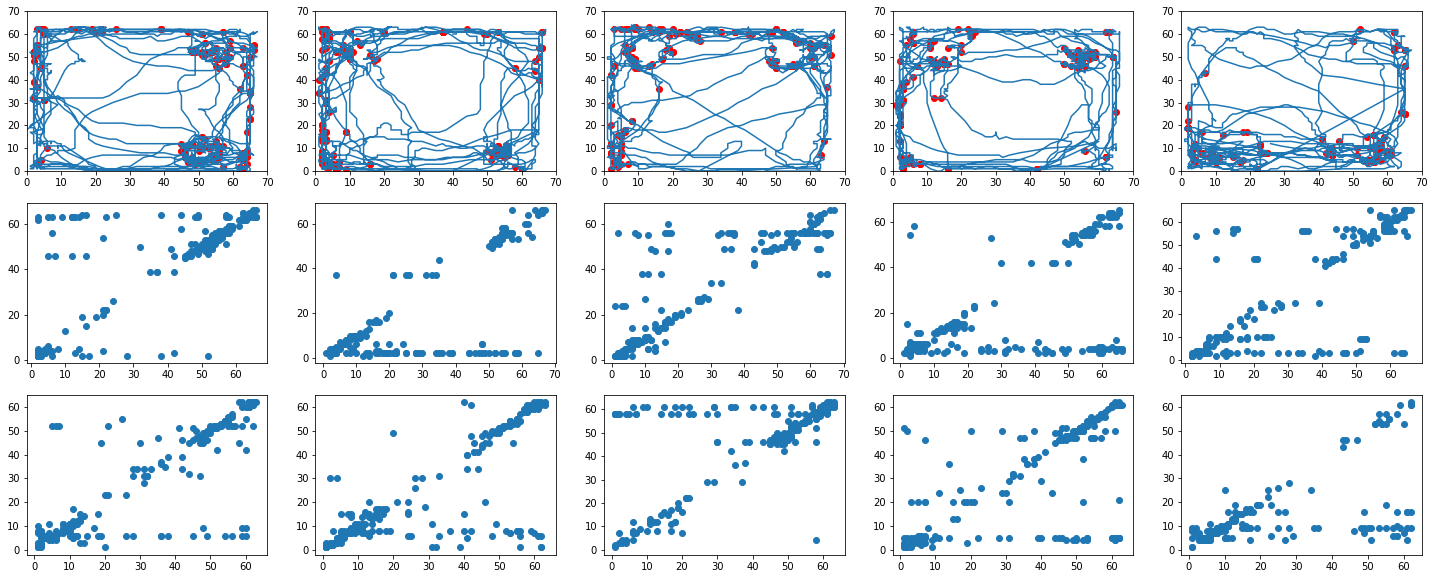

In [227]:
figure , axes = plt.subplots(3,5)

for trial in range(5):
    
    y_pred = y_pred_list[trial]
    y_test = y_test_list[trial]
    
    y_pred_x = [int(y_pred[i]/BINS) for i in range(len(y_pred))]
    y_pred_y = [y_pred[i]%BINS for i in range(len(y_pred))]

    y_test_x = [int(y_test[i]/BINS) for i in range(len(y_test))]
    y_test_y = [y_test[i]%BINS for i in range(len(y_test))]

    x_dist = np.array([ y_pred_x[i] - y_test_x[i] for i in range(len(y_pred_x))])
    y_dist = np.array([ y_pred_y[i] - y_test_y[i] for i in range(len(y_pred_x))])
     
    distance = np.sqrt((x_dist)*(x_dist)+(y_dist)*(y_dist))
    print('MeanError: ' + str(np.mean(distance)) + ' Std: ' + str(np.std(distance)))
    print('MeanErrorProp: ' + str(np.mean(distance)/BINS) + ' PRopStd: ' + str(np.std(distance)/BINS))
    
    axes[0,trial].plot(ypre_list[trial][:,0],ypre_list[trial][:,1])
    axes[0,trial].scatter(y_pred_x,y_pred_y,color = 'r')
    axes[0,trial].set_xlim([0,BINS])
    axes[0,trial].set_ylim([0,BINS])

    axes[1,trial].scatter(y_test_x,y_pred_x)

    axes[2,trial].scatter(y_test_y,y_pred_y)
    figure.set_size_inches(25,10)


In [228]:
distance_trial = []
distance_trial_shuffle = []

distance_trial_std = []
distance_trial_std_shuffle = []

for trial in range(5*4):
    
    y_pred = y_pred_list[trial]
    y_test = y_test_list[trial]
    
    y_pred_x = [int(y_pred[i]/BINS) for i in range(len(y_pred))]
    y_pred_y = [y_pred[i]%BINS for i in range(len(y_pred))]

    y_test_x = [int(y_test[i]/BINS) for i in range(len(y_test))]
    y_test_y = [y_test[i]%BINS for i in range(len(y_test))]

    x_dist = np.array([ y_pred_x[i] - y_test_x[i] for i in range(len(y_pred_x))])
    y_dist = np.array([ y_pred_y[i] - y_test_y[i] for i in range(len(y_pred_x))])
    distance = np.sqrt((x_dist)*(x_dist)+(y_dist)*(y_dist))
    distance_trial.append(np.mean(distance))
    distance_trial_std.append(np.std(distance))
    
        
    y_pred = y_pred_list_shuffle[trial]
    y_test = y_test_list_shuffle[trial]
    
    y_pred_x = [int(y_pred[i]/BINS) for i in range(len(y_pred))]
    y_pred_y = [y_pred[i]%BINS for i in range(len(y_pred))]

    y_test_x = [int(y_test[i]/BINS) for i in range(len(y_test))]
    y_test_y = [y_test[i]%BINS for i in range(len(y_test))]

    x_dist = np.array([ y_pred_x[i] - y_test_x[i] for i in range(len(y_pred_x))])
    y_dist = np.array([ y_pred_y[i] - y_test_y[i] for i in range(len(y_pred_x))])
    distance = np.sqrt((x_dist)*(x_dist)+(y_dist)*(y_dist))
    distance_trial_shuffle.append(np.mean(distance))
    distance_trial_std_shuffle.append(np.std(distance))
    


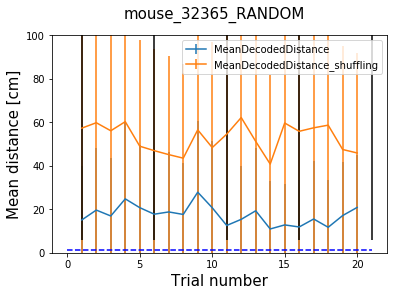

In [229]:
figure, axes = plt.subplots(1)

axes.errorbar(np.arange(1,len(distance_trial)+1),np.array(distance_trial)*100/BINS,np.array(distance_trial_std)*100/BINS)
axes.errorbar(np.arange(1,len(distance_trial_shuffle)+1),np.array(distance_trial_shuffle)*100/BINS,np.array(distance_trial_shuffle)*100/BINS)
axes.legend(['MeanDecodedDistance','MeanDecodedDistance_shuffling'])
axes.set_xlabel('Trial number', fontsize = 15)
axes.set_ylabel('Mean distance [cm]', fontsize = 15)
axes.set_ylim([0,100])

plt.vlines(1, 6, 100, colors='k', linestyles='-')
plt.vlines(6, 6, 100, colors='k', linestyles='-')
plt.vlines(11, 6, 100, colors='k', linestyles='-')
plt.vlines(16, 6, 100, colors='k', linestyles='-')
plt.vlines(21, 6, 100, colors='k', linestyles='-')
plt.hlines((700/BINS)/7, 0, 21, colors='b', linestyles='--') 

figure.suptitle('mouse_' + f'{mouse}' + '_' + task , fontsize = 15)

figure_name = 'position_decoder_naive_bayes_'+'mouse_' + f'{mouse}' + '_' + task +'_BINS_'+f'{BINS}' +'.png'
figure.savefig(figure_path + figure_name)

In [230]:
print(BINS)

70
